In [1]:
#Predict whether posts come from depression or suicide thread

import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix

import seaborn as sns #only responded to pip install (not pip3 install or conda install)
import matplotlib.pyplot as plt
from matplotlib import cm
from nltk.corpus import stopwords
from collections import Counter
import itertools

In [2]:
df_suicide = pd.read_csv('suicidewatch_posts.csv')
df_depression = pd.read_csv('depression_posts.csv')

In [3]:
# Create column 'Suicide', intialize with 1
df_suicide['Suicide'] = 1
df_depression['Depression'] = np.nan

print(len(df_suicide)) # Check
df_suicide.head(1) # Check

2861


,title,score,p_id,subreddit,url,num_comments,body,p_timestamp,c_id,comment,c_timestamp,Post_Reply,Time_to_Comment,Suicide
0,New wiki on how to avoid accidentally encourag...,1777,cz6nfd,SuicideWatch,https://www.reddit.com/r/SuicideWatch/comments...,251,We've been seeing a worrying increase in pro-s...,2019-09-03 21:19:51,eyx1qcc,I'm sorry did you say suicide fetishists? As i...,2019-09-04 02:04:05,Y,0 days 04:44:14,1


In [18]:
# Create column 'Depression', intialize with 0
df_depression['Suicide'] = np.nan
df_depression['Depression'] = 0

print(len(df_depression)) # Check
df_depression.head(1) # Check

list(df_depression['comment'][:1])
print("\n")

list(df_suicide['comment'][1:2])


3903




['I didn’t necessarily see this addressed, perhaps I overlooked it. I personally think the whole “it gets better” campaign was BS. It’s not 100% true, yay for those whose lives have improved and they can honestly look back and say wow, I’m really glad I didn’t die. Is that little bandaid still discouraged? I hope so. Because as someone who has wanted to die (not necessarily kill myself) since I was probably at least 25, and I’m now 48 and at the lowest point I’ve been, it does not get better. And it can get worse. I would never encourage anyone to kill themselves. But if their mind is made up, I want them to know it’s ok, I want them to be at peace because it’s obviously not with them now.']

In [5]:
# Merge the two datasets
frames = [df_depression, df_suicide]
df_merged = pd.concat(frames, sort=True)

print('df_merged length:', len(df_merged)) # Check
df_merged.head(1) # Check

print('Bayesian accuracy')
print(4447/8482)
print(1-4447/8482)

df_merged length: 6764
Bayesian accuracy
0.5242867248290497
0.4757132751709503


In [6]:
# Split into train and test set
df_merged['Target'] = df_merged['Suicide'].combine_first(df_merged['Depression'])

df_merged['Target'].value_counts() # Check
df_merged.head(3)

,Depression,Post_Reply,Suicide,Time_to_Comment,body,c_id,c_timestamp,comment,num_comments,p_id,p_timestamp,score,subreddit,title,url,Target
0,0.0,Y,NaN,0 days 01:01:36,We understand that most people who reply immed...,f5pot56,2019-10-29 21:23:38,Understood and I apologise if I forget in the ...,180,doqwow,2019-10-29 20:22:02,2361,depression,Our most-broken and least-understood rules is ...,https://www.reddit.com/r/depression/comments/d...,0.0
1,0.0,Y,NaN,0 days 01:01:37,We understand that most people who reply immed...,f5pot7j,2019-10-29 21:23:39,I agree wholeheartedly. When you're strugglin...,180,doqwow,2019-10-29 20:22:02,2361,depression,Our most-broken and least-understood rules is ...,https://www.reddit.com/r/depression/comments/d...,0.0
2,0.0,Y,NaN,3 days 19:19:33,We understand that most people who reply immed...,f647tsy,2019-11-02 15:41:35,Biggest Problem on private talks may be that y...,180,doqwow,2019-10-29 20:22:02,2361,depression,Our most-broken and least-understood rules is ...,https://www.reddit.com/r/depression/comments/d...,0.0


In [7]:
# Clean comments

sw = stopwords.words('english')

# Replace '\n' and '\\' with ''
df_merged['comment'] = df_merged['comment'].astype(str).str.replace('\n', '').str.replace('\\', '')

# Remove stopwords
# df_merged['comment_sw'] = df_merged['comment'].apply(lambda x: ' '.join([word for word in x.split() if word not in (sw)])).astype(str)

# Remove special characters; make all characters lowercase
df_merged['comment_sw_p'] = df_merged['comment'].str.replace('[^\w\s]', '').str.lower()

# Create boolean for deleted comments
df_merged['deleted'] = np.where(df_merged['comment']=='[deleted]', 'Y', 'N')

# Create column with comment length
df_merged['comment_length'] = 0

for i in range(len(df_merged)):
    df_merged['comment_length'].iloc[i] = len(df_merged['comment'].iloc[i].split(' '))
    
df_merged['comment_length'] = np.where(df_merged['deleted']=='Y', np.NaN, df_merged['comment_length'])
df_merged.head(1)

C:\Users\HARSHI~1\AppData\Local\Temp/ipykernel_9448/2600204507.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_merged['comment'] = df_merged['comment'].astype(str).str.replace('\n', '').str.replace('\\', '')
C:\Users\HARSHI~1\AppData\Local\Temp/ipykernel_9448/2600204507.py:12: FutureWarning: The default value of regex will change from True to False in a future version.
  df_merged['comment_sw_p'] = df_merged['comment'].str.replace('[^\w\s]', '').str.lower()
C:\Users\Harshitha\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,Depression,Post_Reply,Suicide,Time_to_Comment,body,c_id,c_timestamp,comment,num_comments,p_id,p_timestamp,score,subreddit,title,url,Target,comment_sw_p,deleted,comment_length
0,0.0,Y,NaN,0 days 01:01:36,We understand that most people who reply immed...,f5pot56,2019-10-29 21:23:38,Understood and I apologise if I forget in the ...,180,doqwow,2019-10-29 20:22:02,2361,depression,Our most-broken and least-understood rules is ...,https://www.reddit.com/r/depression/comments/d...,0.0,understood and i apologise if i forget in the ...,N,13.0


In [8]:
#Train and run Logistic Regression model using unigrams and bigrams

# Ref: https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f
# Sublinear tf scaling: https://nlp.stanford.edu/IR-book/html/htmledition/sublinear-tf-scaling-1.html
# min_df: When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold. 
# norm: cosine similarity between two vectors is their dot product when l2 norm has been applied
# ngram_range: an ngram_range of (1, 1) means only unigrams, (1, 2) means unigrams and bigrams, and (2, 2) means only bigrams
tfidf1 = TfidfVectorizer(sublinear_tf = True, min_df = 3, norm = 'l2', ngram_range = (1,1))
tfidf12 = TfidfVectorizer(sublinear_tf = True, min_df = 3, norm = 'l2', ngram_range = (1,2))
tfidf123 = TfidfVectorizer(sublinear_tf = True, min_df = 3, norm = 'l2', ngram_range = (1,3))

features1 = tfidf1.fit_transform(df_merged.comment_sw_p).toarray()
features12 = tfidf12.fit_transform(df_merged.comment_sw_p).toarray()
features123 = tfidf123.fit_transform(df_merged.comment_sw_p).toarray()

print(features1.shape)
print(features12.shape)
print(features123.shape)# Each comment is represented by 6948 features, which are tf-idf scores for various unigrams and bigrams


(6764, 4197)
(6764, 19100)
(6764, 26869)


In [9]:
def train_test_split_predict_verify(features, targets, random_state = 42):
    X_train, X_test, y_train, y_test = train_test_split(features, targets, random_state = random_state)
    
    # Predict subreddit class based on tf-idf scores using Logistic Regression model
    models = [LogisticRegression(penalty = 'l2', random_state = random_state, solver = 'liblinear')]
    CV = 5
    entries = []
    class_names = ['Depression', 'Suicide']

    for model in models:

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        conf_matrix = confusion_matrix(y_test, y_pred)

        print (conf_matrix)

        np.set_printoptions(precision = 2)

        # Plot non-normalized and normalized confusion matrix
        titles_options = [("Confusion matrix, without normalization", None), ("Normalized confusion matrix", 'true')]
        for title, normalize in titles_options:
            disp = plot_confusion_matrix(model, X_test, y_test, display_labels = class_names, cmap = plt.cm.Reds, normalize = normalize)
            disp.ax_.set_title(title)
            print(title)
            print(disp.confusion_matrix)
        plt.show()

        model_name = model.__class__.__name__
        print (model_name)

        accuracies = cross_val_score(model, features, df_merged.Target, scoring = 'accuracy', cv = CV) # cross_val_score(estimator, X, y)
        for fold_index, accuracy in enumerate(accuracies):
            entries.append((model_name, fold_index, accuracy))

    cv_df = pd.DataFrame(entries, columns = ['model_name', 'fold_index','accuracy'])
    cv_df


Unigrams
[[714 270]
 [341 366]]
Confusion matrix, without normalization
[[714 270]
 [341 366]]
Normalized confusion matrix
[[0.73 0.27]
 [0.48 0.52]]


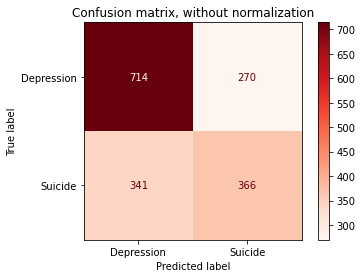

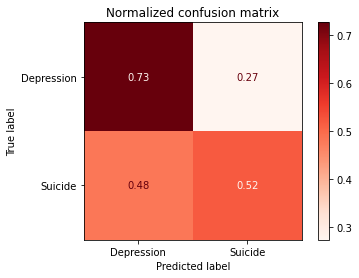

LogisticRegression
Unigrams and bigrams
[[755 229]
 [392 315]]
Confusion matrix, without normalization
[[755 229]
 [392 315]]
Normalized confusion matrix
[[0.77 0.23]
 [0.55 0.45]]


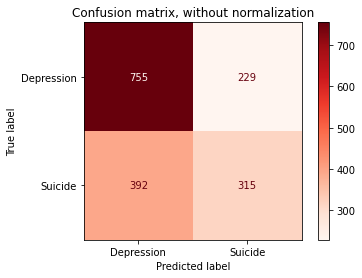

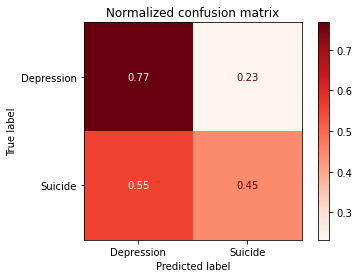

LogisticRegression
Unigrams, bigrams, and trigrams
[[762 222]
 [404 303]]
Confusion matrix, without normalization
[[762 222]
 [404 303]]
Normalized confusion matrix
[[0.77 0.23]
 [0.57 0.43]]


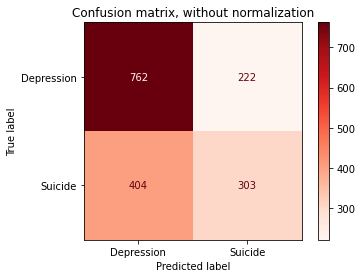

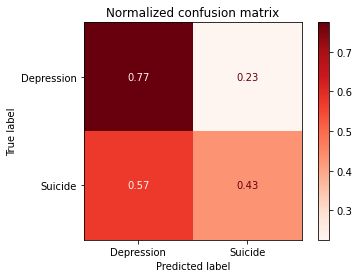

LogisticRegression


In [10]:
# Prediction using unigrams performed about as well as n-grams > 1.
# This implies tf-idf scores of single words can reasonably predict whether a comment was posted in the suicide or depression thread.
print('Unigrams')
train_test_split_predict_verify(features1, df_merged['Target'])

print('Unigrams and bigrams')
train_test_split_predict_verify(features12, df_merged['Target'])

print('Unigrams, bigrams, and trigrams')
train_test_split_predict_verify(features123, df_merged['Target'])

In [11]:
#Depression
d = list(itertools.chain(*[comment.split() for comment, tgt in zip(df_merged['comment_sw_p'], df_merged['Target']) if tgt == 0]))
print("Depression most common words: ")
depression_most_common = Counter(d)

Depression most common words: 


In [12]:
# Normalize term frequencies
number_tokens = sum(depression_most_common.values())

for word, frequency in depression_most_common.most_common(20):
    word_norm = frequency/number_tokens


In [13]:
# Top 5 words in merged dataset by tf-idf score

feature_array = np.array(tfidf1.get_feature_names())
response = tfidf1.transform(df_merged.comment_sw_p)
tfidf_sorting = np.argsort(response.toarray()).flatten()[::-1]

n = 5
top_n = feature_array[tfidf_sorting][:n]
# len(feature_array)
# response
print('Top 5 unigrams in merged set')
top_n

Top 5 unigrams in merged set


array(['autopilot', 'moment', 'knowing', 'brain', 'struggling'],
      dtype='<U17')

In [14]:
# Top 5 words in depression dataset by tf-idf score

# Replace '\n' and '\\' with ''
df_depression['comment'] = df_depression['comment'].astype(str).str.replace('\n', '').str.replace('\\', '')

# Remove special characters; make all characters lowercase
df_depression['comment_sw_p'] = df_depression['comment'].str.replace('[^\w\s]', '').str.lower()

feature_array = np.array(tfidf1.get_feature_names())
response = tfidf1.transform(df_depression.comment_sw_p)
tfidf_sorting = np.argsort(response.toarray()).flatten()[::-1]

n = 5
top_n = feature_array[tfidf_sorting][:n]
# len(feature_array)
# response
print('Top 5 unigrams in depression set')
top_n

C:\Users\HARSHI~1\AppData\Local\Temp/ipykernel_9448/1435895412.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_depression['comment'] = df_depression['comment'].astype(str).str.replace('\n', '').str.replace('\\', '')
C:\Users\HARSHI~1\AppData\Local\Temp/ipykernel_9448/1435895412.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  df_depression['comment_sw_p'] = df_depression['comment'].str.replace('[^\w\s]', '').str.lower()


Top 5 unigrams in depression set


array(['nan', 'zu', 'favorite', 'fate', 'father'], dtype='<U17')

In [15]:
# Top 5 words in suicide dataset by tf-idf score

# Replace '\n' and '\\' with ''
df_suicide['comment'] = df_suicide['comment'].astype(str).str.replace('\n', '').str.replace('\\', '')

# Remove special characters; make all characters lowercase
df_suicide['comment_sw_p'] = df_suicide['comment'].str.replace('[^\w\s]', '').str.lower()

feature_array = np.array(tfidf1.get_feature_names())
response = tfidf1.transform(df_suicide.comment_sw_p)
tfidf_sorting = np.argsort(response.toarray()).flatten()[::-1]

n = 5
top_n = feature_array[tfidf_sorting][:n]
# len(feature_array)
# response
print ('Top 5 unigrams in suicide set')
top_n


C:\Users\HARSHI~1\AppData\Local\Temp/ipykernel_9448/2175026657.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_suicide['comment'] = df_suicide['comment'].astype(str).str.replace('\n', '').str.replace('\\', '')
C:\Users\HARSHI~1\AppData\Local\Temp/ipykernel_9448/2175026657.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  df_suicide['comment_sw_p'] = df_suicide['comment'].str.replace('[^\w\s]', '').str.lower()


Top 5 unigrams in suicide set


array(['autopilot', 'moment', 'knowing', 'brain', 'struggling'],
      dtype='<U17')

In [17]:
#Suicide
s = list(itertools.chain(*[comment.split() for comment, tgt in zip(df_merged['comment_sw_p'], df_merged['Target']) if tgt == 1])) 
print(" most common words: ")
suicide_most_common = Counter(s)
suicide_most_common.most_common(20)

 most common words: 


[('i', 3635),
 ('to', 3517),
 ('you', 3058),
 ('and', 2365),
 ('the', 2222),
 ('a', 1954),
 ('it', 1536),
 ('that', 1462),
 ('of', 1259),
 ('is', 1215),
 ('for', 1112),
 ('but', 1067),
 ('in', 1002),
 ('my', 930),
 ('your', 830),
 ('have', 812),
 ('im', 810),
 ('be', 803),
 ('not', 768),
 ('me', 762)]